<a href="https://colab.research.google.com/gist/helgi17-gb/20f34d8cbccce56f4c9200c92ee76999/lipetsk2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Загрузим нужные библиотеки

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from os import listdir 

import cv2

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms
from torchvision.models import resnet18


from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import clear_output

%matplotlib inline

/usr/local/lib/python3.7/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
import multiprocessing
from psutil import virtual_memory

ram_gb = round(virtual_memory().total / 1024**3, 1)

print('CPU:', multiprocessing.cpu_count())
print('RAM GB:', ram_gb)
print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("cuDNN version:", torch.backends.cudnn.version())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device.type)

!nvidia-smi

CPU: 2
RAM GB: 12.7
PyTorch version: 1.12.1+cu102
CUDA version: 10.2
cuDNN version: 7605
device: cuda
Mon Oct 10 22:18:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    12W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------

In [3]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)


In [4]:
!pip install timm
!pip install git+https://github.com/huggingface/transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-a822f5wh
  Running command git clone -q https://github.com/huggingface/transformers /tmp/pip-req-build-a822f5wh
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [5]:
from timm import create_model
from transformers import DistilBertModel, DistilBertTokenizer, DistilBertConfig#, get_linear_schedule_with_warmup

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

## Загрузим набор данных

In [ ]:
!wget https://lodmedia.hb.bizmrg.com/case_files/837418/train_dataset_train.zip

--2022-10-10 20:48:07--  https://lodmedia.hb.bizmrg.com/case_files/837418/train_dataset_train.zip
Resolving lodmedia.hb.bizmrg.com (lodmedia.hb.bizmrg.com)... 217.69.142.100
Connecting to lodmedia.hb.bizmrg.com (lodmedia.hb.bizmrg.com)|217.69.142.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 441897856 (421M) [application/zip]
Saving to: ‘train_dataset_train.zip’

train_dataset_train 100%[===================>] 421.43M   269KB/s    in 26m 53s 

2022-10-10 21:15:01 (268 KB/s) - ‘train_dataset_train.zip’ saved [441897856/441897856]



In [ ]:
!wget https://lodmedia.hb.bizmrg.com/case_files/837418/test_dataset_test.zip

--2022-10-10 21:15:01--  https://lodmedia.hb.bizmrg.com/case_files/837418/test_dataset_test.zip
Resolving lodmedia.hb.bizmrg.com (lodmedia.hb.bizmrg.com)... 217.69.142.100
Connecting to lodmedia.hb.bizmrg.com (lodmedia.hb.bizmrg.com)|217.69.142.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 191817805 (183M) [application/zip]
Saving to: ‘test_dataset_test.zip’

test_dataset_test.z   3%[                    ]   5.68M   280KB/s    eta 11m 8s 

In [ ]:
!unzip ./train_dataset_train.zip

In [ ]:
!unzip ./test_dataset_test.zip

In [6]:
train_path = '/content/train/'
test_path = '/content/test/'

In [7]:
df_train = pd.read_csv("/content/train.csv")

Преобразуем в таблицу для использования RuCLIP

In [8]:
df= df_train
df=df.rename(columns={"description": "text", "object_img": "image_name"})
df=df.drop(columns=["id"])


Добавим расширения файлов

In [9]:
df['image_name'] = df['image_name'].apply(lambda x: str(x)+'.png')

## Train test split

In [10]:
train_df, val_df = train_test_split(df, test_size=0.1, random_state=655)

In [11]:
train_df.to_csv('clip_train.csv', index=False)
val_df.to_csv('clip_val.csv', index=False)

## RuCLIPTiny

Подгружаем RuCLIPTiny

In [ ]:
%%capture
!gdown -O ru-clip-tiny.pkl https://drive.google.com/uc?id=1-3g3J90pZmHo9jbBzsEmr7ei5zm3VXOL

!pip install git+https://github.com/cene555/ru-clip-tiny.git
!pip install git+https://github.com/Lednik7/CLIP-ONNX.git
!pip install onnxruntime-gpu

!wget -c -O CLIP.png https://github.com/openai/CLIP/blob/main/CLIP.png?raw=true


In [13]:
from rucliptiny.predictor import Predictor
#from rucliptiny.trainer import Trainer  # Для класса Trainer требуется зависимость, которая не устанавливается, 
                                          # поэтому реализуем метод самостоятельно
from rucliptiny import RuCLIPtiny
from rucliptiny.dataset import RuCLIPTinyDataset
import torch

torch.manual_seed(1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
device = 'cuda'
model = RuCLIPtiny().to(device)
model.load_state_dict(torch.load('/content/ru-clip-tiny.pkl'))


<All keys matched successfully>

Реализуем класс Trainer вместо класса из репозитория RuCLIPTiny. Единственное отличие в неиспользовании scheduler'а

In [12]:
tokenizer_load = "DeepPavlov/distilrubert-tiny-cased-conversational-v1"
tokenizer = DistilBertTokenizer.from_pretrained(tokenizer_load)


In [15]:
import torch
#from transformers import get_linear_schedule_with_warmup
from tqdm.auto import tqdm



class Trainer:
    def __init__(self, train_dataframe, train_dir,
                 val_dataframe=None, val_dir=None, learning_rate=1e-4,
                 freeze_image_encoder=True, freeze_text_encoder=False, max_text_len=77,
                 train_batch_size=64, val_batch_size=64, num_workers=2,
                 weight_decay=1e-4, grad_accum=8):
        self.train_dataframe = train_dataframe
        self.train_dir = train_dir
        self.val_dataframe = val_dataframe
        self.val_dir = val_dir
        self.learning_rate = learning_rate
        self.freeze_image_encoder = freeze_image_encoder
        self.freeze_text_encoder = freeze_text_encoder
        self.max_text_len = max_text_len
        self.train_batch_size = train_batch_size
        self.val_batch_size = val_batch_size
        self.num_workers = num_workers
        self.weight_decay = weight_decay
        self.grad_accum = grad_accum
        print(f"train batch size = {self.train_batch_size * self.grad_accum}")

    def train_model(self, model, epochs_num=1, device='cuda', verbose=10):

        is_val = self.val_dataframe is not None and self.val_dir is not None

        model.to(device)

        train_dataset = RuCLIPTinyDataset(self.train_dir, self.train_dataframe, self.max_text_len)

        train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                                    batch_size=self.train_batch_size,
                                                    shuffle=True,
                                                    pin_memory=True,
                                                    num_workers=self.num_workers)

        if is_val:
            val_dataset = RuCLIPTinyDataset(self.val_dir, self.val_dataframe, self.max_text_len)
            val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                                     batch_size=self.val_batch_size,
                                                     shuffle=False,
                                                     pin_memory=True,
                                                     num_workers=self.num_workers)

        for i, child in enumerate(model.children()):
            if (i == 0 and self.freeze_image_encoder) or (i == 1 and self.freeze_text_encoder):
                for param in child.parameters():
                    param.requires_grad = False

        loss_img = torch.nn.CrossEntropyLoss()
        loss_txt = torch.nn.CrossEntropyLoss()

        optimizer = torch.optim.AdamW(model.parameters(), lr=self.learning_rate, betas=(0.9, 0.98), eps=1e-8,
                                          weight_decay=self.weight_decay)
        total_steps = len(train_loader) * epochs_num
        #scheduler = get_linear_schedule_with_warmup(optimizer,
        #                                                num_warmup_steps=0,
        #                                                num_training_steps=total_steps)

        for epoch in range(epochs_num):
            model.train()
            print(f'start training epoch {epoch}')
            curr_batch = 0
            X = []
            Y = []
            curr_batch = 0
            for i, batch in enumerate(tqdm(train_loader)):
                images = batch[0].cuda()
                input_ids = batch[1].cuda()
                attention_mask = batch[2].cuda()

                image_features = model.encode_image(images)
                text_features = model.encode_text(input_ids, attention_mask)

                image_features = image_features / image_features.norm(dim=-1, keepdim=True)
                text_features = text_features / text_features.norm(dim=-1, keepdim=True)

                X.append(image_features)
                Y.append(text_features)

                if ((i + 1) % self.grad_accum == 0) or (i + 1 == len(train_loader)):
                    optimizer.zero_grad()
                    X = torch.cat(X, axis=0).cuda()
                    Y = torch.cat(Y, axis=0).cuda()
                    logit_scale = model.logit_scale.exp()
                    logits_per_image = logit_scale * X @ Y.t()
                    logits_per_text = logits_per_image.t()
                    ground_truth = torch.arange(X.shape[0], dtype=torch.long).cuda()
                    img_l = loss_img(logits_per_image, ground_truth)
                    text_l = loss_txt(logits_per_text, ground_truth)
                    total_loss = (img_l + text_l) / 2
                    if curr_batch % verbose == 0:
                        print(f'{i}/{len(train_loader)} total_loss {total_loss}')
                    total_loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
                    optimizer.step()
                    #scheduler.step()
                    
                    X = []
                    Y = []
                    curr_batch += 1
            if is_val:
                print(f'start val epoch {epoch}')
                total_loss = 0
                model.eval()
                with torch.no_grad():
                    for i, batch in enumerate(tqdm(val_loader)):
                        images = batch[0].to(device)
                        input_ids = batch[1].to(device)
                        attention_mask = batch[2].to(device)

                        logits_per_image, logits_per_text = model(images, input_ids, attention_mask)
                        ground_truth = torch.arange(batch[1].shape[0], dtype=torch.long).to(device)
                        img_l = loss_img(logits_per_image, ground_truth).item()
                        text_l = loss_txt(logits_per_text, ground_truth).item()
                        total_loss += (img_l + text_l) / 2
                    print(f'val loss = {total_loss / len(val_loader)}')
        return model

In [ ]:
#torch.cuda.empty_cache()

In [16]:
trainer = Trainer(train_dataframe='clip_train.csv', train_dir='train/',
                  val_dataframe='clip_val.csv', val_dir='train/',
                  train_batch_size=32, grad_accum=16,  max_text_len=177)

train batch size = 512


In [17]:
model = trainer.train_model(model, epochs_num=4, device=device, verbose=2)

start training epoch 0


  0%|          | 0/59 [00:00<?, ?it/s]

15/59 total_loss 4.788758754730225
47/59 total_loss 4.431992530822754
start val epoch 0


  0%|          | 0/4 [00:00<?, ?it/s]

val loss = 1.8392002582550049
start training epoch 1


  0%|          | 0/59 [00:00<?, ?it/s]

15/59 total_loss 4.122864723205566
47/59 total_loss 3.96500563621521
start val epoch 1


  0%|          | 0/4 [00:00<?, ?it/s]

val loss = 1.6418545693159103
start training epoch 2


  0%|          | 0/59 [00:00<?, ?it/s]

15/59 total_loss 3.8087406158447266
47/59 total_loss 3.7022581100463867
start val epoch 2


  0%|          | 0/4 [00:00<?, ?it/s]

val loss = 1.520370438694954
start training epoch 3


  0%|          | 0/59 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbae6661e60>
Exception ignored in: Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fbae6661e60>    
self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
        self._shutdown_workers()if w.is_alive():

  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
        if w.is_alive():assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError  File "/usr/lib/python3.7/multiprocessing/process.py"

15/59 total_loss 3.5604352951049805
47/59 total_loss 3.537584066390991
start val epoch 3


  0%|          | 0/4 [00:00<?, ?it/s]

val loss = 1.4414241015911102


## Predict RuCLIPTiny

In [18]:
predictor = Predictor()

In [19]:
df_test = pd.read_csv("/content/test.csv")

In [20]:
dft= df_test
dft=dft.rename(columns={"description": "text"})
dft=dft.drop(columns=["id"])

In [21]:
import os
images = []
img_paths = []

for filename in [filename for filename in os.listdir("/content/test") if
                     filename.endswith('.png') or filename.endswith('.jpg')]:
        name = os.path.splitext(filename)[0]
        fn = os.path.join("/content/test", filename)
        img_paths.append(fn)
        image = Image.open(fn)
        images.append(fn)

In [22]:
text_probs = predictor(model=model, images_path=images,
                       classes=dft['text'], get_probs=True,
                       max_len=177, device=device)

In [23]:
similarity = text_probs.cpu().numpy()

0.0017007906
0.0010693748
675 0.0014651295
843 Фотография. Традиционные лыжные соревнования на ПГПИ. Победители.  ПОКМ-18530/2203 фотопечать,фотобумага    Лыжин А. (Фотограф) 


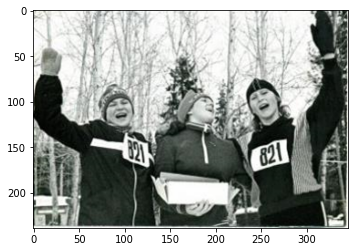

max:  0.0014651295


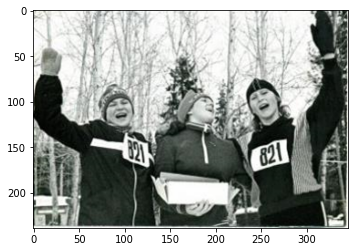

In [24]:
import matplotlib.pyplot as plt

print(np.max(similarity[:,:]))
print(similarity[133,33])
i = 675
#for j in range(similarity.shape[0]):
  
j = np.argmax(similarity[i,:])
print(i, similarity[i, j])
print(j, dft['text'][j])
im = Image.open(images[i])
plt.imshow(im)
plt.show()
k = np.argmax(similarity[:, j])
print("max: ", similarity[k, j])
im1 = Image.open(images[k])
plt.imshow(im1)
plt.show()

## Получение результатов

В предыдущем блоке мы получили матрицу попарной похожести (скалярных произведений) similarity.
Чтобы получить результат, будем выбирать наиболее похожие между собой пары, которые еще не были выбраны.

In [25]:
usedtext = set()
usedimg = set()
pairs = []

pair = (-1,-1)
for k in range(0,900):
  maxval = 0
  for t in (set(range(0,900))-usedtext):
    for im in (set(range(0,900))-usedimg):
      if (similarity[im,t] > maxval):
        maxval = similarity[im,t]
        pair = (im,t)

  usedtext.add(pair[1])
  usedimg.add(pair[0])
  pairs.append(pair)
print(k)

899


Сформируем массив предсказанных значений картинок без расширения файла

In [26]:
predicts = []
for p in pairs:
  predicts.append(os.path.basename(images[p[0]]).split(".")[0])

Объединим массив описаний и предсказанных значений

In [27]:
submit_df = pd.DataFrame([[name, pred] for name, pred in zip(df_test['id'], predicts)], columns=['description', 'object_img'])

In [28]:
submit_df.to_csv("submit.csv", index=False)

Визуальная проверка

237 Фотонегатив пленочный. Торжественное собрание, посвящённое 50-летию СССР. Выступает 1-ый секретарь горкома КПСС С.А. Мелешков.  ПОКМ-15000/56 фотосъемка,пленка    Загуляев Евгений Николаевич (Фотограф) Изображение сцены, на которой за кафедрой выступает мужчина, рядом сидят мужчины в форме. На заднем плане видна часть бюста Ленина.


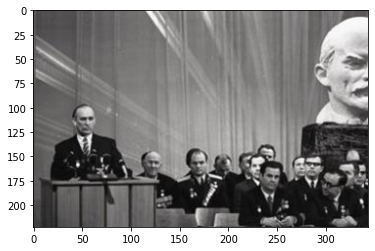

36 0.0014726968
237 Фотонегатив пленочный. Торжественное собрание, посвящённое 50-летию СССР. Выступает 1-ый секретарь горкома КПСС С.А. Мелешков.  ПОКМ-15000/56 фотосъемка,пленка    Загуляев Евгений Николаевич (Фотограф) Изображение сцены, на которой за кафедрой выступает мужчина, рядом сидят мужчины в форме. На заднем плане видна часть бюста Ленина.


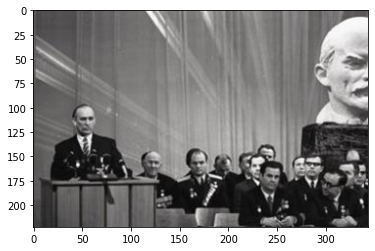

In [29]:
k = 300
print(pairs[k][1], dft['text'][pairs[k][1]])
im1 = Image.open(images[pairs[k][0]])
plt.imshow(im1)
plt.show()
j = pairs[k][1]
i = np.argmax(similarity[:,j])
print(i, similarity[i, j])
print(j, dft['text'][j])
im = Image.open(images[i])
plt.imshow(im)
plt.show()